Note: The inspiration for the structural model of code has been taken from https://github.com/ananyahjha93/cycle-consistent-vae. Although all the models, dataloaders and analysis based code are purely original.

All the console outputs are logged into 'Log' folder as 'txt' files.


In [0]:
import os
from google.colab import drive

In [2]:
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/DL_Group/Assignments/Assignment_3')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#IMPORT LIBS 


In [0]:
import h5py
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
from mpl_toolkits.axes_grid1 import ImageGrid
import random
import torch
from torch.utils.data import DataLoader,TensorDataset
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from itertools import cycle
import h5py
import time
from matplotlib import gridspec
from sklearn.utils import shuffle
import matplotlib.gridspec as gridspec
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Dataset Processing


In [0]:

def load_data(data_path):
    data=h5py.File(data_path,'r')
    x=data['x']
    y=data['y']
    x=np.array(x,dtype=np.float16)
    y=np.array(y)
    return (x,y)



In [0]:
traina,trainb=load_data('Datasets/Q2/train_data.h5')
  

In [0]:
a,b=load_data('Datasets/Q2/val_data.h5')


In [0]:
testa,testb=load_data('Datasets/Q2/test_data.h5')


#HELPER FUNCTIONS





In [0]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.transforms import Compose, ToTensor
# from PIL import Image


# compose a transform configuration
transform_config = Compose([ToTensor()])


def mse_loss(input, target):
    return torch.sum((input - target).pow(2)) / input.data.nelement()


def l1_loss(input, target):
    return torch.sum(torch.abs(input - target)) / input.data.nelement()

def l2_loss(pred,target):
    loss=torch.sum((pred-target).pow(2))/pred.data.nelement()
    return loss

def reparameterize(training, mu, logvar):
    if training:
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)
    else:
        return mu


def weights_init(layer):
    if isinstance(layer, nn.Conv2d):
        layer.weight.data.normal_(0.0, 0.05)
        layer.bias.data.zero_()
    elif isinstance(layer, nn.BatchNorm2d):
        layer.weight.data.normal_(1.0, 0.02)
        layer.bias.data.zero_()
    elif isinstance(layer, nn.Linear):
        layer.weight.data.normal_(0.0, 0.05)
        layer.bias.data.zero_()
def accuracy(pred,y):
  count=0
  for i in range(len(pred)):
    idx=torch.argmax(pred[i])
    idx_class=torch.argmax(y[i])
    if idx.item()==idx_class.item():
      count+=1
  return count/len(y)

def imshow_grid(images, shape=[2, 8], name='default', save=False):
    """
    Plot images in a grid of a given shape.
    Initial code from: https://github.com/pumpikano/tf-dann/blob/master/utils.py
    """
    fig = plt.figure(1)
    grid = ImageGrid(fig, 111, nrows_ncols=shape, axes_pad=0.05)
    size = shape[0] * shape[1]
    for i in range(size):
        grid[i].axis('off')
        # print(images[i])
        grid[i].imshow(images[i])  # The AxesGrid object work as a list of axes.

    if save:
        plt.savefig('reconstructed_images/' + str(name) + '.png')
        plt.clf()
    else:
        plt.show()

DATA LOADING FOR THE MODEL



In [0]:
import random
import numpy as np
from itertools import cycle
from torchvision import datasets,transforms
from torch.utils.data import Dataset, DataLoader

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample[0], sample[1]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return (torch.from_numpy(image),torch.from_numpy(landmarks))

class MNIST_Paired():
    def __init__(self, x,y=[],train=True, transform=None):
        self.dat=x  

        self.data_dict = {}

        for i in range(self.__len__()):
            image,label = self.dat[i]

            try:
                self.data_dict[label.item()]
            except KeyError:
                self.data_dict[label.item()] = []
            self.data_dict[label.item()].append(image)

    def __len__(self):
        return len(self.dat)

    def __getitem__(self, index):
        image= self.dat[index][0]
        label=self.dat[index][1]


        # return another image of the same class randomly selected from the data dictionary
        # this is done to simulate pair-wise labeling of data
        return image, random.SystemRandom().choice(self.data_dict[label.item()]), label


MODEL DEFINITION

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.autograd import Variable
from torch.utils.data import DataLoader

from itertools import cycle
from collections import OrderedDict
# from utils import reparameterize, transform_config


class Encoder(nn.Module):
    def __init__(self, style_dim, class_dim):
        super(Encoder, self).__init__()

        self.conv_model = nn.Sequential(OrderedDict([
            ('convolution_1',
             nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=2, padding=1, bias=True)),
            ('convolution_1_in', nn.InstanceNorm2d(num_features=16, track_running_stats=True)),
            ('ReLU_1', nn.ReLU(inplace=True)),

            ('convolution_2',
             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=1, bias=True)),
            ('convolution_2_in', nn.InstanceNorm2d(num_features=32, track_running_stats=True)),
            ('ReLU_2', nn.ReLU(inplace=True)),

            ('convolution_3',
             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=1, bias=True)),
            ('convolution_3_in', nn.InstanceNorm2d(num_features=64, track_running_stats=True)),
            ('ReLU_3', nn.ReLU(inplace=True)),

            ('convolution_4',
             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=1, bias=True)),
            ('convolution_4_in', nn.InstanceNorm2d(num_features=128, track_running_stats=True)),
            ('ReLU_4', nn.ReLU(inplace=True))
        ]))

        # Style embeddings
        self.style_mu = nn.Linear(in_features=512, out_features=style_dim, bias=True)
        self.style_logvar = nn.Linear(in_features=512, out_features=style_dim, bias=True)

        # Class embeddings
        self.class_output = nn.Linear(in_features=512, out_features=class_dim, bias=True)

    def forward(self, x):
        x = self.conv_model(x)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        style_embeddings_mu = self.style_mu(x)
        style_embeddings_logvar = self.style_logvar(x)
        class_embeddings = self.class_output(x)

        return style_embeddings_mu, style_embeddings_logvar, class_embeddings


class Decoder(nn.Module):
    def __init__(self, style_dim, class_dim):
        super(Decoder, self).__init__()

        # Style embeddings input
        self.style_input = nn.Linear(in_features=style_dim, out_features=512, bias=True)

        # Class embeddings input
        self.class_input = nn.Linear(in_features=class_dim, out_features=512, bias=True)

        self.deconv_model = nn.Sequential(OrderedDict([
            ('deconvolution_1',
             nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=4, stride=2, padding=0, bias=True)),
            ('deconvolution_1_in', nn.InstanceNorm2d(num_features=64, track_running_stats=True)),
            ('LeakyReLU_1', nn.LeakyReLU(negative_slope=0.2, inplace=True)),

            ('deconvolution_2',
             nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=0, bias=True)),
            ('deconvolution_2_in', nn.InstanceNorm2d(num_features=32, track_running_stats=True)),
            ('LeakyReLU_2', nn.LeakyReLU(negative_slope=0.2, inplace=True)),

            ('deconvolution_3',
             nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=0, bias=True)),
            ('deconvolution_3_in', nn.InstanceNorm2d(num_features=16, track_running_stats=True)),
            ('LeakyReLU_3', nn.LeakyReLU(negative_slope=0.2, inplace=True)),

            ('deconvolution_4',
             nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=4, stride=2, padding=1, bias=True)),
            ('sigmoid_final', nn.Sigmoid())
        ]))

    def forward(self, style_embeddings, class_embeddings):
        style_embeddings = F.leaky_relu_(self.style_input(style_embeddings), negative_slope=0.2)
        class_embeddings = F.leaky_relu_(self.class_input(class_embeddings), negative_slope=0.2)

        x = torch.cat((style_embeddings, class_embeddings), dim=1)
        x = x.view(x.size(0), 256, 2, 2)
        x = self.deconv_model(x)

        return x


class Classifier(nn.Module):
    def __init__(self, z_dim, num_classes):
        super(Classifier, self).__init__()

        self.fc_model = nn.Sequential(OrderedDict(  [
            ('fc_1', nn.Linear(in_features=z_dim, out_features=256, bias=True)),
            ('fc_1_bn', nn.BatchNorm1d(num_features=256)),
            ('LeakyRelu_1', nn.LeakyReLU(negative_slope=0.2, inplace=True)),

            ('fc_2', nn.Linear(in_features=256, out_features=256, bias=True)),
            ('fc_2_bn', nn.BatchNorm1d(num_features=256)),
            ('LeakyRelu_2', nn.LeakyReLU(negative_slope=0.2, inplace=True)),

            ('fc_3', nn.Linear(in_features=256, out_features=num_classes, bias=True))
        ]))

    def forward(self, z):
        x = self.fc_model(z)

        return x



#**TRAINING ONLY**




In [13]:
def cycle(iterable):
    iterator = iter(iterable)
    while True:
        try:
            yield next(iterator)
        except StopIteration:
            iterator = iter(iterable)
a=np.moveaxis(a,0,-1)      
a=a/255.0
a=np.moveaxis(a,-1,0)      
print(a.shape)
# val_Data = MNIST_Paired(a,b,transform=transforms.Compose([ToTensor()]))
val_f=TensorDataset(torch.from_numpy(a).to(device),torch.from_numpy(b).to(device))
val_Data=MNIST_Paired(val_f)
val_loader = cycle(DataLoader(val_Data, batch_size=64, shuffle=False, num_workers=0, drop_last=True))
 



(12816, 3, 60, 60)


In [14]:
traina=traina/255.0
traina=traina.astype('float')
print(traina.shape)
# train_Data = MNIST_Paired(traina,trainb,transform=transforms.Compose([ToTensor()]))
# train_loader = cycle(DataLoader(train_Data, batch_size=64, shuffle=False,drop_last=True))  
train_df=TensorDataset(torch.from_numpy(traina),torch.from_numpy(trainb))
train_Data = MNIST_Paired(train_df)
train_loader = cycle(DataLoader(train_Data, batch_size=64, shuffle=False,drop_last=True))  


(89000, 3, 60, 60)


In [0]:
# testa=testa/255.0
# testa=testa.astype('float')
# print(testa.shape)
# test_Data = MNIST_Paired(testa,testb,transform=transforms.Compose([ToTensor()]))
# test_loader = cycle(DataLoader(test_Data, batch_size=64, shuffle=False, num_workers=0, drop_last=True))

In [0]:
batch_size=64
train_batches=len(train_Data)//batch_size

In [0]:
val_batches=len(val_Data)//batch_size


In [17]:
import os
import numpy as np
from itertools import cycle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
# from utils import imshow_grid, mse_loss, reparameterize, l1_loss

# FLAGS={}
image_size=60
num_channels=3 #RGB
initial_learning_rate=0.0001
style_dim=512
class_dim=512
num_classes=672
reconstruction_coef=2
reverse_cycle_coef=10
kl_divergence_coef=3
beta_1=0.9
beta_2=0.999
encoder_save='encoderwts'
decoder_save='decoderwts'
log_file='Outputs/Q2/logs.txt'
load_saved=False
# print(FLAGS)
epochs=100


encoder = Encoder(style_dim,class_dim).to(device)
encoder.apply(weights_init)
decoder = Decoder(style_dim,class_dim).to(device)
decoder.apply(weights_init)

########### if saved and want to finetune

# if load_saved:
#   encoder.load_state_dict(torch.load(os.path.join('Outputs/Q2/checkpoints', encoder_save)))
#   decoder.load_state_dict(torch.load(os.path.join('Outputs/Q2/checkpoints', decoder_save)))



Decoder(
  (style_input): Linear(in_features=512, out_features=512, bias=True)
  (class_input): Linear(in_features=512, out_features=512, bias=True)
  (deconv_model): Sequential(
    (deconvolution_1): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2))
    (deconvolution_1_in): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (LeakyReLU_1): LeakyReLU(negative_slope=0.2, inplace=True)
    (deconvolution_2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2))
    (deconvolution_2_in): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (LeakyReLU_2): LeakyReLU(negative_slope=0.2, inplace=True)
    (deconvolution_3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2))
    (deconvolution_3_in): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (LeakyReLU_3): LeakyReLU(negative_slope=0.2, inplace=True)
    (deconvolution_4): ConvTranspose2d(16, 3, kernel_si

In [0]:
reconstruction_loss_list,kl_div_loss_list,reverse_cycle_loss_list=[],[],[]
x1 = torch.FloatTensor(batch_size, num_channels, image_size, image_size).to(device)
x2 = torch.FloatTensor(batch_size, num_channels, image_size, image_size).to(device)
x3 = torch.FloatTensor(batch_size, num_channels, image_size, image_size).to(device)
style_latent_space = torch.FloatTensor(batch_size, style_dim).to(device)



forward_optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),lr=initial_learning_rate)
reverse_optimizer = optim.Adam(list(encoder.parameters()),lr=initial_learning_rate)
forward_optim_scheduler = optim.lr_scheduler.StepLR(forward_optimizer, step_size=80, gamma=0.1)
reverse_optim_scheduler = optim.lr_scheduler.StepLR(reverse_optimizer, step_size=80, gamma=0.1)




# load_saved is false when training is started from 0th iteration
# if not FLAGS.load_saved:
# with open(FLAGS.log_file, 'w') as log:
# log.write('Epoch\tIteration\tReconstruction_loss\tKL_divergence_loss\tReverse_cycle_loss\n')

In [0]:
if not os.path.exists('Outputs/Q2/checkpoints/encoder_weights_new'):
  os.makedirs('Outputs/Q2/checkpoints/encoder_weights_new')
if not os.path.exists('Outputs/Q2/checkpoints/decoder_weights_new'):
  os.makedirs('Outputs/Q2/checkpoints/decoder_weights_new')
if not os.path.exists('Outputs/Q2/reconstructed_images'):
  os.makedirs('Outputs/Q2/reconstructed_images')

In [0]:
#disconnected colab at 97th epoch running from last checkpoint
# encoder.load_state_dict(torch.load('Outputs/Q2/checkpoints/encoder_weights_new/encoder99.pt'))
# decoder.load_state_dict(torch.load('Outputs/Q2/checkpoints/decoder_weights_new/decoder99.pt'))
# epochs=100


In [25]:

for epoch in range(epochs):
  print('')
  start=time.time()
  print('Epoch #' + str(epoch+100) + '..........................................................................')
  loss1=0
  loss2=0
  loss3=0
  # update the learning rate scheduler
  forward_optim_scheduler.step()
  reverse_optim_scheduler.step()

  for iteration in range(train_batches):
    forward_optimizer.zero_grad()

    image_batch_1, image_batch_2, _ = next(train_loader)
    # forward go


    x1.copy_(image_batch_1)
    x2.copy_(image_batch_2)

    style_mu_1,style_logvar_1,class_latent_space_1=encoder(Variable(x1))
    style_latent_space_1=reparameterize(training=False,mu=style_mu_1,logvar=style_logvar_1)
    kl_divergence_loss_1 = kl_divergence_coef * (-0.5*torch.sum(1+style_logvar_1-style_mu_1.pow(2)-style_logvar_1.exp()))/(batch_size*num_channels *image_size * image_size)
    kl_divergence_loss_1.backward(retain_graph=True)

    style_mu_2,style_logvar_2,class_latent_space_2=encoder(Variable(x2))
    style_latent_space_2=reparameterize(training=False,mu=style_mu_2,logvar=style_logvar_2)
    kl_divergence_loss_2 = kl_divergence_coef *(- 0.5 * torch.sum(1 + style_logvar_2 - style_mu_2.pow(2) - style_logvar_2.exp()))/(batch_size * num_channels * image_size * image_size) 
    kl_divergence_loss_2.backward(retain_graph=True)

    reconstructed_x1=decoder(style_latent_space_1, class_latent_space_2)
    reconstructed_x2=decoder(style_latent_space_2, class_latent_space_1)
    
    reconstruction_error_1=reconstruction_coef*l2_loss(reconstructed_x1,Variable(x1))
    reconstruction_error_1.backward(retain_graph=True)
    reconstruction_error_2=reconstruction_coef*l2_loss(reconstructed_x2,Variable(x2))
    reconstruction_error_2.backward()
    
    reconstruction_error = (reconstruction_error_1+reconstruction_error_2)
    reconstruction_error/=reconstruction_coef
    kl_divergence_error=(kl_divergence_loss_1 + kl_divergence_loss_2) 
    kl_divergence_error/=kl_divergence_coef

    forward_optimizer.step()

    # reverse cycle
    reverse_optimizer.zero_grad()

    image_batch_1, _, __=next(train_loader)
    image_batch_2, _, __=next(train_loader)
    
    style_latent_space.normal_(0., 1.)
    x1.copy_(image_batch_1)
    x2.copy_(image_batch_2)
    _, __, class_latent_space_1=encoder(Variable(x1))
    _, __, class_latent_space_2=encoder(Variable(x2))

    reconstructed_x2=decoder(Variable(style_latent_space),class_latent_space_2.detach())
    style_mu_2, style_logvar_2,_=encoder(reconstructed_x2)
    style_latent_space_2=reparameterize(training=False, mu=style_mu_2, logvar=style_logvar_2)
    reconstructed_x1=decoder(Variable(style_latent_space),class_latent_space_1.detach())
    style_mu_1, style_logvar_1,_=encoder(reconstructed_x1)
    style_latent_space_1=reparameterize(training=False, mu=style_mu_1, logvar=style_logvar_1)

    reverse_cycle_loss=reverse_cycle_coef*l1_loss(style_latent_space_1,style_latent_space_2)
    reverse_cycle_loss.backward()
    reverse_cycle_loss/=reverse_cycle_coef

    reverse_optimizer.step()

    loss1+=reconstruction_error.data.storage().tolist()[0]
    loss2+=kl_divergence_error.data.storage().tolist()[0]
    loss3+=reverse_cycle_loss.data.storage().tolist()[0]

    

  reverse_cycle_loss_list.append(loss3/train_batches)
  kl_div_loss_list.append(loss2/train_batches)
  reconstruction_loss_list.append(loss1/train_batches)

  # save model after every 5 epochs
  if (epoch + 1) % 5 == 0 or (epoch + 1) == epochs:
    torch.save(encoder.state_dict(), 'Outputs/Q2/checkpoints/encoder_weights_new/encoder'+str(epoch+100)+'.pt')
    torch.save(decoder.state_dict(), 'Outputs/Q2/checkpoints/decoder_weights_new/decoder'+str(epoch+100)+'.pt')
  
  
  print('Epoch ',epoch+1+100,'/',200,' epoch_duration:',str(time.time()-start),'s',' reconstruction_loss:',str(loss1/train_batches),' kl_div_loss:',str(loss2/train_batches),' reverse_cycle_loss:',str(loss3/train_batches))



Epoch #100..........................................................................
Epoch  101 / 200  epoch_duration: 100.42211246490479 s  reconstruction_loss: 0.004176303050849292  kl_div_loss: 0.00012180277403622444  reverse_cycle_loss: 1.0892600791788178e-06

Epoch #101..........................................................................
Epoch  102 / 200  epoch_duration: 100.74502182006836 s  reconstruction_loss: 0.004146802773290455  kl_div_loss: 0.00011947119904061438  reverse_cycle_loss: 1.04776075906484e-06

Epoch #102..........................................................................
Epoch  103 / 200  epoch_duration: 100.82378363609314 s  reconstruction_loss: 0.0041780218597595314  kl_div_loss: 0.00012307957051051346  reverse_cycle_loss: 1.119131002632508e-06

Epoch #103..........................................................................
Epoch  104 / 200  epoch_duration: 100.84977602958679 s  reconstruction_loss: 0.004131680544090571  kl_div_loss: 0.0001183

In [0]:
## OUTPUT OF THE TRAIN LOGGED AT log.txt

In [0]:
reconstruction_loss_list=['8.686999438088488e-05', '4.269123199251782e-05', '2.1179927396116924e-05', '1.0709047545061765e-05', '5.6343378006374265e-06', '3.188040495646576e-06', '2.02006064131533e-06', '1.463808805608927e-06', '1.1958591330243926e-06', '1.0627330056990196e-06', '9.940594822977892e-07', '9.575120591405642e-07', '9.374113942318454e-07', '9.258824681258132e-07', '9.189525180380174e-07', '9.144328097993317e-07', '9.112714108779472e-07', '9.08837065538091e-07', '9.068687751773363e-07', '9.052816743297895e-07', '9.039488737625165e-07', '9.027927261014555e-07', '9.018257205000429e-07', '9.009862176724369e-07', '9.002361025931932e-07', '8.996191514015401e-07', '8.990166013469245e-07', '8.984561278951025e-07', '8.978820072789865e-07', '8.97442961920644e-07', '8.970996717959397e-07', '8.96716516072963e-07', '8.963562669800562e-07', '8.960511599702153e-07', '8.9576371821828e-07', '8.954733684551828e-07', '8.952041250624539e-07', '8.950332957849515e-07', '8.948145313520039e-07', '8.945997608030967e-07', '8.944161137026921e-07', '8.942379519513132e-07', '8.940749799473955e-07', '8.939443301338058e-07', '8.937733140091231e-07', '8.936592314757748e-07', '8.935118760765892e-07', '8.933755950840232e-07', '8.933095619654818e-07', '8.931808614313189e-07', '8.930786031060902e-07', '8.929968376921463e-07', '8.928584272387839e-07', '8.927694156384552e-07', '8.926644725453908e-07', '8.925860888241344e-07', '8.924989106080895e-07', '8.924600879843166e-07', '8.92386941300403e-07', '8.922977178254317e-07', '8.92263050782734e-07', '8.921467239975991e-07', '8.920679044222721e-07', '8.919822654360418e-07', '8.919161582983722e-07', '8.918503328014405e-07', '8.918063267121803e-07', '8.917286277292013e-07', '8.916866463289108e-07', '8.916302924995539e-07', '8.915765838521124e-07', '8.915492647005351e-07', '8.877864256434065e-07', '8.876439422159518e-07', '8.876295590725145e-07', '8.87617662644627e-07', '8.876070513278457e-07', '8.875973987836941e-07', '8.875795577201355e-07', '8.875717077257799e-07', '8.875638150375184e-07', '8.875565515527407e-07', '8.875495381381115e-07', '8.875427159872737e-07', '8.875364376521077e-07', '8.875309498085149e-07', '8.87523862783703e-07', '8.875185907815236e-07', '8.875121722189597e-07', '8.875064426068113e-07', '8.87501758177468e-07', '8.87495939987733e-07', '8.874913145692196e-07', '8.874865324428062e-07', '8.874822563863987e-07', '8.874764373378783e-07']

In [0]:
reverse_cycle_loss_list=['4.707272468811739e-06', '2.6501810468367996e-06', '1.4749440365269182e-06', '8.054847523172291e-07', '4.525515653627938e-07', '2.708283743800984e-07', '1.5085091391858323e-07', '9.641950230398645e-08', '8.847828442342381e-08', '6.55811960554832e-08', '5.6773074667348214e-08', '5.21840590371819e-08', '4.990178399229123e-08', '4.802152098448937e-08', '6.681784010295122e-07', '1.9332751661228265e-07', '1.265028668510106e-07', '1.0344338351908701e-07', '9.71053237857658e-08', '9.157948052078734e-08', '8.11206840891579e-08', '8.538353690522095e-08', '7.310827568972763e-08', '6.748690528044083e-08', '6.622117333273086e-08', '5.9342840532517484e-08', '5.617290101524464e-08', '5.5106348085178397e-08', '5.0582306895548196e-08', '4.822717490971362e-08', '4.623837549710803e-08', '4.466634141945522e-08', '4.296147278821389e-08', '4.094390084975962e-08', '3.921948738338346e-08', '3.777341974812349e-08', '3.605224368825328e-08', '3.4731797741584295e-08', '3.3302909738940894e-08', '3.2038269880080337e-08', '3.0755434332938336e-08', '2.946532622626333e-08', '2.8067926966488104e-08', '2.6615413253024544e-08', '2.5198999341845146e-08', '2.3909380318604162e-08', '2.253214889042234e-08', '2.1176340311666186e-08', '1.979399154064392e-08', '1.8455478375909585e-08', '1.71285889529525e-08', '1.58348342221078e-08', '1.4578857620409244e-08', '1.339639200274127e-08', '1.2247314902603596e-08', '1.1129319790927762e-08', '1.0060414945875806e-08', '9.078821535964052e-09', '8.135074069857204e-09', '7.290312463706712e-09', '6.52487921950112e-09', '5.82191203032594e-09', '5.201716388081392e-09', '4.644014358679404e-09', '4.152162998399623e-09', '3.734565138989804e-09', '3.3612490646932165e-09', '3.035969489875024e-09', '2.7653941772800417e-09', '2.533018675385785e-09', '2.3524644492991937e-09', '2.193701717800627e-09', '2.0699441898340583e-09', '2.0522661517439184e-09', '2.038994847943803e-09', '2.0282522028010513e-09', '2.015443019350916e-09', '2.0033219567640286e-09', '1.979950767048299e-09', '1.9706624846748515e-09', '1.9592423376725297e-09', '1.9501554764330503e-09', '1.9385394277026357e-09', '1.930051341449584e-09', '1.9201938518048913e-09', '1.9119587187657706e-09', '1.902277260972044e-09', '1.891916719690234e-09', '1.881838760359868e-09', '1.871549126147243e-09', '1.8645449718962498e-09', '1.856300657712076e-09', '1.8485684437222863e-09', '1.842696810566582e-09', '1.8354789843897124e-09', '1.8267566922765197e-09']

In [0]:
kl_div_loss_list=['7.443934558857023e-07', '5.076582914030336e-07', '3.63301266769432e-07', '2.76420196690805e-07', '2.4651075964831383e-07', '2.7875008207598617e-07', '3.0789541179653737e-07', '3.605410653756853e-07', '4.143392753079876e-07', '4.2704175105389945e-07', '4.992279627299958e-07', '5.345434403283853e-07', '5.002465674643684e-07', '4.000425379159561e-07', '4.873048310617659e-07', '1.6925274307960607e-07', '1.236494621353051e-07', '9.752275688775926e-08', '9.381564365522493e-08', '1.1349518633684586e-07', '7.371429386254192e-08', '2.7326041259535935e-07', '1.722071698017392e-07', '2.056276956413918e-07', '2.6753034815579737e-07', '1.0328117336522489e-07', '1.0582008432103923e-07', '1.4445032183410233e-07', '8.421658749936956e-08', '6.987070748163788e-08', '6.414850094185842e-08', '6.031600562187777e-08', '5.925637496016557e-08', '5.2439107407774566e-08', '4.860964064840964e-08', '5.316329406565787e-08', '4.5238488610470834e-08', '4.432438050551325e-08', '4.2539275495899184e-08', '4.177832016837214e-08', '4.1438524122235575e-08', '4.2460512776770647e-08', '4.0021676621521e-08', '3.9396676864376795e-08', '3.8663511865161697e-08', '3.8517822744921455e-08', '3.743467412312788e-08', '3.666546753629273e-08', '3.6273676055819174e-08', '3.584918586126549e-08', '3.5263152221744006e-08', '3.477396607723413e-08', '3.433776850900083e-08', '3.4844314588902395e-08', '3.4051052193083756e-08', '3.3744188335657844e-08', '3.349724857269544e-08', '3.32443361996367e-08', '3.3005249549239006e-08', '3.2896913697678356e-08', '3.272922082098732e-08', '3.24403577279896e-08', '3.246739855767692e-08', '3.224058896243111e-08', '3.21558567923099e-08', '3.199498556549853e-08', '3.1933765778464996e-08', '3.1815430512658084e-08', '3.179021454585347e-08', '3.1592735423749827e-08', '3.153815368925399e-08', '3.14687145598275e-08', '1.900816982391334e-09', '1.9260805082749227e-09', '2.0739896987659045e-09', '2.1303050314987283e-09', '2.1279555076458765e-09', '2.114566139135075e-09', '2.0854353239489425e-09', '2.0739751827196656e-09', '2.063673061053923e-09', '2.051614444678307e-09', '2.0418082654683323e-09', '2.0313635152876756e-09', '2.0220653042456294e-09', '2.013666918102428e-09', '2.0048476226885594e-09', '1.9964421435780572e-09', '1.9877647494430854e-09', '1.979247102343857e-09', '1.9705849113154444e-09', '1.963677817313977e-09', '1.955609707344891e-09', '1.9484894812734767e-09', '1.9409863518207987e-09', '1.9333334337932912e-09']

In [0]:
for i in range(96):
  reconstruction_loss_list[i]=float(reconstruction_loss_list[i])
  reverse_cycle_loss_list[i]=float(reverse_cycle_loss_list[i])
  kl_div_loss_list[i]=float(kl_div_loss_list[i])


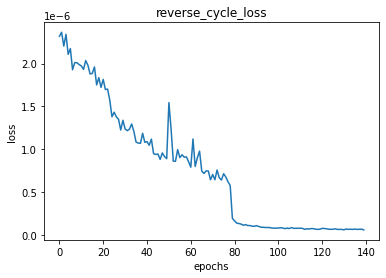

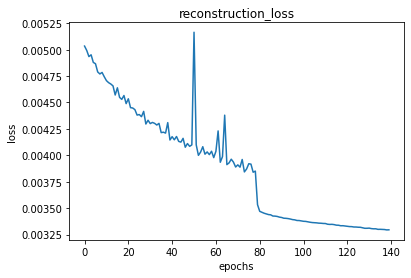

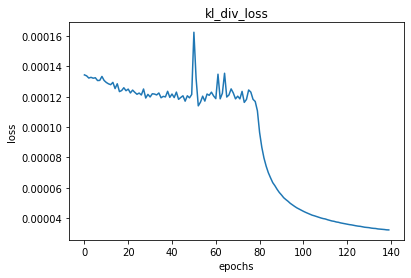

In [26]:
plt.figure()
plt.title('reverse_cycle_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(reverse_cycle_loss_list)

plt.figure()
plt.title('reconstruction_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(reconstruction_loss_list)

plt.figure()
plt.title('kl_div_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(kl_div_loss_list)



#QUESTION 5 - UNSPECIFIED TO SPECIFIED 

THIS LOADING IS FOR REST OF THE Qs


In [36]:


a=a/255.0
a=a.astype('float')
print(a.shape)
val_d=TensorDataset(torch.from_numpy(a),torch.from_numpy(b))
val_Data = MNIST_Paired(val_d)
val_loader = (DataLoader(val_Data, batch_size=64, shuffle=True, num_workers=0, drop_last=True))

traina=traina/255.0
traina=traina.astype('float')
print(traina.shape)
# train_Data = MNIST_Paired(traina,trainb,transform=transforms.Compose([ToTensor()]))
# train_loader = cycle(DataLoader(train_Data, batch_size=64, shuffle=False,drop_last=True))  
train_df=TensorDataset(torch.from_numpy(traina),torch.from_numpy(trainb))
train_Data = MNIST_Paired(train_df)
train_loader = (DataLoader(train_Data, batch_size=64, shuffle=True,drop_last=True))  

# testa=testa/255.0
# testa=testa.astype('float')
# print(testa.shape)
# test_d=TensorDataset(torch.from_numpy(testa),torch.from_numpy(testb))
# test_Data = MNIST_Paired(test_d)
# test_loader = (DataLoader(test_Data, batch_size=64, shuffle=True, num_workers=0, drop_last=True))


(12816, 3, 60, 60)
(89000, 3, 60, 60)


bELOW Loader is req in Q2

In [12]:
testa=testa/255.0
testa=testa.astype('float')
print(testa.shape)
test_df=TensorDataset(torch.from_numpy(testa),torch.from_numpy(testb))
test_Data = MNIST_Paired(test_df)
test_loader = (DataLoader(test_Data, batch_size=64, shuffle=True, num_workers=0, drop_last=True))

(17800, 3, 60, 60)


In [0]:
batch_size=64
train_batches=len(train_Data)//batch_size

In [0]:
val_batches=len(val_Data)//batch_size

In [0]:
class Predictor(nn.Module):
    def __init__(self,in_dim,out_dim):
        super(Predictor,self).__init__()
        self.f1=nn.Linear(in_dim,256)
        self.batch_norm1=nn.BatchNorm1d(num_features=256)
        self.f2=nn.Linear(256,256)
        self.batch_norm2=nn.BatchNorm1d(num_features=256)
        self.f3=nn.Linear(256,out_dim)

    def forward(self,x):
        x=self.f1(x)
        x=self.batch_norm1(x)
        x=F.relu(x)
        x=self.f2(x)
        x=self.batch_norm2(x)
        x=F.relu(x)
        x=self.f3(x)
        return x



In [17]:

image_size=60
num_channels=3 #RGB
initial_learning_rate=0.0001
style_dim=512
class_dim=512
num_classes=672
reconstruction_coef=2.
reverse_cycle_coef=10.
kl_divergence_coef=3.
beta_1=0.9
beta_2=0.999
log_file='Outputs/Q2/logs.txt'
load_saved=False
# print(FLAGS)
epochs=20


ztospredictor=Predictor(style_dim,class_dim).to(device)

encoder=Encoder(style_dim,class_dim).to(device)
decoder=Decoder(style_dim,class_dim).to(device)
encoder.load_state_dict(torch.load('Outputs/Q2/checkpoints/encoder_weights_new/encoder199.pt'))
decoder.load_state_dict(torch.load('Outputs/Q2/checkpoints/decoder_weights_new/decoder199.pt'))

print(ztospredictor)





Predictor(
  (batch_norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (f1): Linear(in_features=512, out_features=256, bias=True)
  (f2): Linear(in_features=256, out_features=256, bias=True)
  (f3): Linear(in_features=256, out_features=512, bias=True)
)


In [25]:
epochs=50
train_loss_list=[]
val_loss_list=[]
criterion=nn.MSELoss()
optim=torch.optim.Adam(ztospredictor.parameters(),lr=0.01)
x1=torch.FloatTensor(batch_size,num_channels,image_size,image_size).to(device)
for epoch in range(epochs):
    train_loss=0
    train_acc=0
    ztospredictor.train()
    val_iterator=iter(val_loader)
    train_iterator=iter(train_loader)
    for i,bat in enumerate(train_iterator):
        x=bat[0]
        x1.copy_(x)
        optim.zero_grad()
        with torch.no_grad():
            style_mu,style_logvar,class_latent=encoder(Variable(x1))
        s_pred=ztospredictor(style_mu)
        loss=criterion(s_pred,class_latent)
        loss.backward()
        optim.step()
        train_loss+=loss.item()
        
  
    ztospredictor.eval()
    validation_loss=0
    with torch.no_grad():
        for i,bat in enumerate(val_iterator):
            x=bat[0]
            x1.copy_(x)
            style_mu,style_logvar,class_latent=encoder(Variable(x1))
            s_pred=ztospredictor(style_mu)
            loss=criterion(s_pred,class_latent)
            validation_loss+=loss.item()


    print('Epoch: '+str(epoch+1)+'/'+str(epochs)+' loss: '+str(train_loss/train_batches)+' val_loss: '+str(validation_loss/val_batches))
    train_loss_list.append(train_loss/train_batches)
    val_loss_list.append(validation_loss/val_batches)
torch.save(ztospredictor.state_dict(),os.getcwd()+'/Outputs/Q2/checkpoints/predictor/ztospredictor.pt')

Epoch: 1/50 loss: 0.00086231579260378 val_loss: 0.0006493871592101641
Epoch: 2/50 loss: 0.0008604410241388133 val_loss: 0.0007400895014870912
Epoch: 3/50 loss: 0.0008397345379641507 val_loss: 0.0006152866902993992
Epoch: 4/50 loss: 0.0008561826825708071 val_loss: 0.000677300356910564
Epoch: 5/50 loss: 0.0008373325025635979 val_loss: 0.0006259722117101774
Epoch: 6/50 loss: 0.0008501763828685038 val_loss: 0.0007505760376807303
Epoch: 7/50 loss: 0.0008350604861596157 val_loss: 0.0006381532142404467
Epoch: 8/50 loss: 0.0008476455098775169 val_loss: 0.0006485862948466092
Epoch: 9/50 loss: 0.0008262543910997082 val_loss: 0.000612467119062785
Epoch: 10/50 loss: 0.0008329502058135038 val_loss: 0.0006932515901280568
Epoch: 11/50 loss: 0.000820523158399214 val_loss: 0.0006834357653860934
Epoch: 12/50 loss: 0.000828463412492985 val_loss: 0.0006349780576420017
Epoch: 13/50 loss: 0.000837042590011943 val_loss: 0.0006626756049809046
Epoch: 14/50 loss: 0.0008257385174134116 val_loss: 0.00063091548538

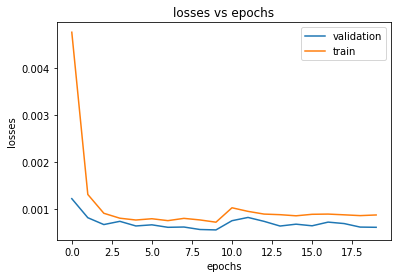

In [19]:
plt.figure()
plt.title('losses vs epochs')
plt.plot(val_loss_list,label='validation')
plt.plot(train_loss_list,label='train')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend(loc='upper right')

In [23]:
testa=testa/255.0
testa=testa.astype('float')
print(testa.shape)
test_d=TensorDataset(torch.from_numpy(testa),torch.from_numpy(testb))
test_Data = MNIST_Paired(test_d)
test_loader = (DataLoader(test_Data, batch_size=64, shuffle=True, num_workers=0, drop_last=True))
test_iterator=iter(test_loader)

(17800, 3, 60, 60)


In [0]:
image_count=0
encoder.load_state_dict(torch.load('Outputs/Q2/checkpoints/encoder_weights_new/encoder199.pt'))
decoder.load_state_dict(torch.load('Outputs/Q2/checkpoints/decoder_weights_new/decoder199.pt'))

ztospredictor=Predictor(style_dim,class_dim).to(device)
ztospredictor.load_state_dict(torch.load('Outputs/Q2/checkpoints/predictor/ztospredictor.pt'))
image_batch=next(test_iterator)[0]
x1.copy_(image_batch)
style_mu,style_logvar,class_latent=encoder(Variable(x1))
s_pred=ztospredictor(style_mu)
reconstructed_img_batch_s=decoder(style_mu,class_latent)
reconstructed_img_batch_s_pred=decoder(style_mu,s_pred)
reconstruction_err=reconstruction_coef*l2_loss(reconstructed_img_batch_s,reconstructed_img_batch_s_pred)
gs=gridspec.GridSpec(8,8,width_ratios=[1,1,1,1,1,1,1,1],height_ratios=[1,1,1,1,1,1,1,1],wspace=0,hspace=0)
reconstructed_img=np.transpose(reconstructed_img_batch_s.cpu().data.numpy(),(0,2,3,1))

fig1=plt.figure(figsize=(8,8))
# fig1.suptitle('Image Reconstructions with encoder generated class-latent space')

for i in range(8):
    for j in range(8):
        if image_count<batch_size:
            ax=plt.subplot(gs[i,j])
            ax.axis('off')
            ax.imshow(reconstructed_img[image_count])
            image_count+=1
image_count=0
reconstructed_img=np.transpose(reconstructed_img_batch_s_pred.cpu().data.numpy(),(0,2,3,1))
fig2=plt.figure(figsize=(8,8))
# fig2.suptitle('Image Reconstructions with network generated class-latent space')

for i in range(8):
    for j in range(8):
        if image_count<batch_size:
            ax=plt.subplot(gs[i,j])
            ax.axis('off')
            ax.imshow(reconstructed_img[image_count])
            image_count+=1

print('Difference in reconstruction error: '+str(reconstruction_err.data.storage().tolist()[0]))

# QUESTION 5 SPECIFIED TO UNSPECIFIED

In [37]:

image_size=60
num_channels=3 #RGB
initial_learning_rate=0.0001
style_dim=512
class_dim=512
num_classes=672
reconstruction_coef=2.
reverse_cycle_coef=10.
kl_divergence_coef=3.
beta_1=0.9
beta_2=0.999
log_file='Outputs/Q2/logs.txt'
load_saved=False
# print(FLAGS)
epochs=20


stozpredictor=Predictor(class_dim,style_dim).to(device)

encoder=Encoder(style_dim,class_dim).to(device)
decoder=Decoder(style_dim,class_dim).to(device)
encoder.load_state_dict(torch.load('Outputs/Q2/checkpoints/encoder_weights_new/encoder199.pt'))
decoder.load_state_dict(torch.load('Outputs/Q2/checkpoints/decoder_weights_new/decoder199.pt'))

print(stozpredictor)





Predictor(
  (f1): Linear(in_features=512, out_features=256, bias=True)
  (batch_norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (f2): Linear(in_features=256, out_features=256, bias=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (f3): Linear(in_features=256, out_features=512, bias=True)
)


In [0]:
train_loss_list=[]
val_loss_list=[]
criterion=nn.MSELoss()
optim=torch.optim.Adam(stozpredictor.parameters(),lr=0.01)
x1=torch.FloatTensor(batch_size,num_channels,image_size,image_size).to(device)
for epoch in range(epochs):
    train_loss=0
    stozpredictor.train()
    val_iterator=iter(val_loader)
    train_iterator=iter(train_loader)
    for i,bat in enumerate(train_iterator):
        x=bat[0]
        x1.copy_(x)
        optim.zero_grad()
        with torch.no_grad():
            style_mu,style_logvar,class_latent=encoder(Variable(x1))
        z_pred=stozpredictor(class_latent)
        loss=criterion(z_pred,style_mu)
        loss.backward()
        optim.step()
        train_loss+=loss.item()
  
    stozpredictor.eval()
    validation_loss=0
    with torch.no_grad():
        for i,bat in enumerate(val_iterator):
            x=bat[0]
            x1.copy_(x)
            style_mu,style_logvar,class_latent=encoder(Variable(x1))
            z_pred=stozpredictor(class_latent)
            loss=criterion(z_pred,style_mu)
            validation_loss+=loss.item()


    print('Epoch: '+str(epoch+1)+'/'+str(epochs)+' loss: '+str(train_loss/train_batches)+' val_loss: '+str(validation_loss/val_batches))
    train_loss_list.append(train_loss/train_batches)
    val_loss_list.append(validation_loss/val_batches)
torch.save(stozpredictor.state_dict(),os.getcwd()+'/Outputs/Q2/checkpoints/predictor/stozpredictor.pt')

In [0]:
plt.figure()
plt.title('losses vs epochs')
plt.plot(val_loss_list,label='validation')
plt.plot(train_loss_list,label='train')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend(loc='upper right')

In [15]:
testa=testa/255.0
testa=testa.astype('float')
print(testa.shape)
test_d=TensorDataset(torch.from_numpy(testa),torch.from_numpy(testb))
test_Data = MNIST_Paired(test_d)
test_loader = (DataLoader(test_Data, batch_size=64, shuffle=True, num_workers=0, drop_last=True))
test_iterator=iter(test_loader)

(17800, 3, 60, 60)


In [0]:
image_count=0
stozpredictor=Predictor(style_dim,class_dim).to(device)
stozpredictor.load_state_dict(torch.load('Outputs/Q2/checkpoints/predictor/stozpredictor.pt'))
image_batch=next(test_iterator)[0]
x1.copy_(image_batch)
style_mu,style_logvar,class_latent=encoder(Variable(x1))
z_pred=stozpredictor(class_latent)
reconstructed_img_batch_s=decoder(style_mu,class_latent)
reconstructed_img_batch_s_pred=decoder(z_pred,class_latent)
reconstruction_err=reconstruction_coef*l2_loss(reconstructed_img_batch_s,reconstructed_img_batch_s_pred)
gs=gridspec.GridSpec(8,8,width_ratios=[1,1,1,1,1,1,1,1],height_ratios=[1,1,1,1,1,1,1,1],wspace=0,hspace=0)
reconstructed_img=np.transpose(reconstructed_img_batch_s.cpu().data.numpy(),(0,2,3,1))

fig1=plt.figure(figsize=(8,8))
# fig1.suptitle('Image Reconstructions with encoder generated class-latent space')

for i in range(8):
    for j in range(8):
        if image_count<batch_size:
            ax=plt.subplot(gs[i,j])
            ax.axis('off')
            ax.imshow(reconstructed_img[image_count])
            image_count+=1
image_count=0
reconstructed_img=np.transpose(reconstructed_img_batch_s_pred.cpu().data.numpy(),(0,2,3,1))
fig2=plt.figure(figsize=(8,8))
# fig2.suptitle('Image Reconstructions with network generated class-latent space')

for i in range(8):
    for j in range(8):
        if image_count<batch_size:
            ax=plt.subplot(gs[i,j])
            ax.axis('off')
            ax.imshow(reconstructed_img[image_count])
            image_count+=1

print('Reconstruction error: '+str(reconstruction_err.data.storage().tolist()[0]))

# QUESTION 4 SPECIFIED PARTITION OF LATENT SPACE

In [19]:
traina=np.moveaxis(traina,0,-1)
traina=traina/255.0
traina=np.moveaxis(traina,-1,0)

print(traina.shape)
# train_Data = MNIST_Paired(traina,trainb,transform=transforms.Compose([ToTensor()]))
# train_loader = cycle(DataLoader(train_Data, batch_size=64, shuffle=False,drop_last=True))  
train_df=TensorDataset(torch.from_numpy(traina).to(device),torch.from_numpy(trainb).to(device))
train_Data = MNIST_Paired(train_df)
batch_size=64
image_size=60
num_channels=3 #RGB
initial_learning_rate=0.0001
style_dim=512
class_dim=512
num_classes=672
reconstruction_coef=2.
reverse_cycle_coef=10.
kl_divergence_coef=3.
beta_1=0.9
beta_2=0.999
log_file='Outputs/Q2/logs.txt'
load_saved=False
# print(FLAGS)
epochs=10

sclassifier=Classifier(class_dim,num_classes).to(device)
sclassifier.apply(weights_init)

criterion=nn.BCELoss()
optimiser=torch.optim.Adam(sclassifier.parameters())
total_params=sum(p.numel() for p in sclassifier.parameters() if p.requires_grad)
print('total_params:'+str(total_params))

print(sclassifier)
datax=[]
datay=[]
train_loss_list=[]
train_acc_list=[]
val_loss_list=[]
val_acc_list=[]

encoder=Encoder(style_dim,class_dim).to(device)
encoder.load_state_dict(torch.load('Outputs/Q2/checkpoints/encoder_weights_new/encoder199.pt'))

idx_list=list(range(0,len(train_df)))
random.shuffle(idx_list)
x,y=train_df.tensors
x=x.cpu().numpy()
y=y.cpu().numpy()

for i in range(len(idx_list)):
    datax.append(x[idx_list[i]])
    datay.append(y[idx_list[i]])
datax=np.array(datax)
datay=np.array(datay)
x_val=datax[int(0.8*len(datax)):]
x_train=datax[0:int(0.8*len(datax))]
y_train=datay[0:int(0.8*len(datay))]
y_val=datay[int(0.8*len(datay)):]


train_d_s=TensorDataset(torch.from_numpy(x_train).to(device),torch.from_numpy(y_train).to(device))
val_d_s=TensorDataset(torch.from_numpy(x_val).to(device),torch.from_numpy(y_val).to(device))
train_loader=DataLoader(train_d_s,shuffle=False,batch_size=batch_size,drop_last=True)
val_loader=DataLoader(val_d_s,batch_size=batch_size,shuffle=False,drop_last=True)


(89000, 3, 60, 60)
total_params:370848
Classifier(
  (fc_model): Sequential(
    (fc_1): Linear(in_features=512, out_features=256, bias=True)
    (fc_1_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (LeakyRelu_1): LeakyReLU(negative_slope=0.2, inplace=True)
    (fc_2): Linear(in_features=256, out_features=256, bias=True)
    (fc_2_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (LeakyRelu_2): LeakyReLU(negative_slope=0.2, inplace=True)
    (fc_3): Linear(in_features=256, out_features=672, bias=True)
  )
)


In [0]:
# import tensorflow
x1=torch.FloatTensor(batch_size,num_channels,image_size,image_size).to(device)
criterion=nn.BCELoss()
for epoch in range(epochs):
    train_iterator=iter(train_loader)
    val_iterator=iter(val_loader)
    epoch_loss=0
    epoch_acc=0
    sclassifier.train()
    for i,bat in enumerate(train_iterator):
        optimiser.zero_grad()
        x=bat[0]
        x1.copy_(x)
        y=bat[1]
        with torch.no_grad():
            style_mu,style_logvar,class_latent=encoder(Variable(x1))
        predicted=sclassifier(class_latent)
        y=y.cpu().detach().numpy()
        y=np.eye(num_classes)[y]
        y=torch.from_numpy(y).float().cuda()
        loss=criterion(predicted,y)
        epoch_loss+=loss.item()
        acc=accuracy(predicted,y)
        epoch_acc+=acc
        loss.backward()
        optimiser.step()
        # print(y.sum())
        # print(loss.item())
        

    # print(epoch_loss)
    train_loss=epoch_loss/len(train_iterator)
    train_acc=epoch_acc/len(train_iterator)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    epoch_loss=0
    epoch_acc=0
    sclassifier.eval()
    for i,bat in enumerate(val_iterator):
        x=bat[0]
        x1.copy_(x)
        y=bat[1]
        with torch.no_grad():
            style_mu,style_logvar,class_latent=encoder(Variable(x1))
        predicted=sclassifier(class_latent)
        

        y=y.cpu().detach().numpy()
        y=np.eye(num_classes)[y]
        y=torch.from_numpy(y).float().cuda()
        loss=criterion(predicted,y)
        epoch_loss+=loss.item()
        acc=accuracy(predicted,y)
        epoch_acc+=acc
    val_loss=epoch_loss/len(val_iterator)
    val_acc=epoch_acc/len(val_iterator)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print('Epoch ',epoch+1,'/',epochs,' loss:',train_loss,' acc:',train_acc,' val_loss:',val_loss,' val_acc:',val_acc)
torch.save(sclassifier.state_dict(),os.getcwd()+'/Outputs/Q2/checkpoints/predictor/sclassifier.pt')

In [0]:

plt.figure()
plt.title('acc vs epochs')
plt.plot(train_acc_list,label='train')
plt.plot(val_acc_list,label='validation')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend(loc='upper left')
plt.figure()
plt.title('loss vs epochs')
plt.plot(train_loss_list,label='train')
plt.plot(val_loss_list,label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')


In [0]:
sclassifier=Classifier(class_dim,num_classes).to(device)
sclassifier.load_state_dict(torch.load(os.getcwd()+'/Outputs/Q2/checkpoints/predictor/sclassifier.pt'))
sclassifier.eval()
test_acc=0
val_iterator=iter(val_loader)
for i,bat in enumerate(val_iterator):
    x=bat[0]
    x1.copy_(x)
    y=bat[1]
    with torch.no_grad():
        style_mu,style_logvar,class_latent=encoder(Variable(x1))
    pred=sclassifier(class_latent)
    y=y.cpu().detach().numpy()
    y=np.eye(num_classes)[y]
    y=torch.from_numpy(y).float().cuda()
    loss=criterion(pred,y)
    acc=accuracy(pred,y)
    test_acc+=acc
print('Test accuracy: '+str((test_acc/len(val_iterator))*100)+'%')

#QUESTION 4 UNSPECIFIED PARTITION OF LATENT SPACE

In [0]:

image_size=60
num_channels=3 #RGB
initial_learning_rate=0.0001
style_dim=512
class_dim=512
num_classes=672
reconstruction_coef=2.
reverse_cycle_coef=10.
kl_divergence_coef=3.
beta_1=0.9
beta_2=0.999
log_file='Outputs/Q2/logs.txt'
load_saved=False
# print(FLAGS)
epochs=10

zclassifier=Classifier(style_dim,num_classes).to(device)
zclassifier.apply(weights_init)
criterion=nn.BCELoss()
optimiser=torch.optim.Adam(zclassifier.parameters())
print(zclassifier)
datax=[]
datay=[]
train_loss_list=[]
train_acc_list=[]
val_loss_list=[]
val_acc_list=[]

encoder=Encoder(style_dim,class_dim).to(device)
encoder.load_state_dict(torch.load('Outputs/Q2/checkpoints/encoder_weights/encoder98.pt'))

idx_list=list(range(0,len(train_df)))
random.shuffle(idx_list)
x,y=train_df.tensors
x=x.cpu().numpy()
y=y.cpu().numpy()

for i in range(len(idx_list)):
    datax.append(x[idx_list[i]])
    datay.append(y[idx_list[i]])
datax=np.array(datax)
datay=np.array(datay)
x_val=datax[int(0.7*len(datax)):]
x_train=datax[0:int(0.7*len(datax))]
y_train=datay[0:int(0.7*len(datay))]
y_val=datay[int(0.7*len(datay)):]


train_d_s=TensorDataset(torch.from_numpy(x_train).to(device),torch.from_numpy(y_train).to(device))
val_d_s=TensorDataset(torch.from_numpy(x_val).to(device),torch.from_numpy(y_val).to(device))
train_loader=DataLoader(train_d_s,shuffle=False,batch_size=batch_size,drop_last=True)
val_loader=DataLoader(val_d_s,batch_size=batch_size,shuffle=False,drop_last=True)


Classifier(
  (fc_model): Sequential(
    (fc_1): Linear(in_features=512, out_features=256, bias=True)
    (fc_1_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (LeakyRelu_1): LeakyReLU(negative_slope=0.2, inplace=True)
    (fc_2): Linear(in_features=256, out_features=256, bias=True)
    (fc_2_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (LeakyRelu_2): LeakyReLU(negative_slope=0.2, inplace=True)
    (fc_3): Linear(in_features=256, out_features=672, bias=True)
  )
)


In [0]:
x1=torch.FloatTensor(batch_size,num_channels,image_size,image_size).to(device)
for epoch in range(epochs):
    train_iterator=iter(train_loader)
    val_iterator=iter(val_loader)
    epoch_loss=0
    epoch_acc=0
    zclassifier.train()
    for i,bat in enumerate(train_iterator):
        x=bat[0]
        x1.copy_(x)
        y=bat[1]
        optimiser.zero_grad()
        with torch.no_grad():
            style_mu,style_logvar,class_latent=encoder(Variable(x1))
        z_latent_space=reparameterize(training=True,mu=style_mu,logvar=style_logvar)
        predicted=zclassifier(z_latent_space)
        y=y.cpu().detach().numpy()
        y=np.eye(num_classes)[y]
        y=torch.from_numpy(y).float().cuda()
        loss=criterion(predicted,y)
        loss.backward()
        optimiser.step()
        epoch_loss+=loss.item()
        # print(epoch_loss)
        acc=accuracy(predicted,y)
        epoch_acc+=acc


    train_loss=epoch_loss/len(train_iterator)
    train_acc=epoch_acc/len(train_iterator)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    epoch_loss=0
    epoch_acc=0
    zclassifier.eval()
    for i,bat in enumerate(val_iterator):
        x=bat[0]
        x1.copy_(x)
        y=bat[1]
        with torch.no_grad():
            style_mu,style_logvar,class_latent=encoder(Variable(x1))
        z_latent_space=reparameterize(training=True,mu=style_mu,logvar=style_logvar)
        predicted=zclassifier(z_latent_space)
        y=y.cpu().detach().numpy()
        y=np.eye(num_classes)[y]
        y=torch.from_numpy(y).float().cuda()
        loss=criterion(predicted,y)
        epoch_loss+=loss.item()
        acc=accuracy(predicted,y)
        epoch_acc+=acc
    val_loss=epoch_loss/len(val_iterator)
    val_acc=epoch_acc/len(val_iterator)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print('Epoch ',epoch+1,'/',epochs,' loss:',train_loss,' acc:',train_acc,' val_loss:',val_loss,' val_acc:',val_acc)
torch.save(zclassifier.state_dict(),os.getcwd()+'/Outputs/Q2/checkpoints/predictor/zclassifier.pt')

In [0]:

plt.figure()
plt.title('acc vs epochs')
plt.plot(train_acc_list,label='train')
plt.plot(val_acc_list,label='validation')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend(loc='upper left')
plt.figure()
plt.title('loss vs epochs')
plt.plot(train_loss_list,label='train')
plt.plot(val_loss_list,label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')


In [0]:
zclassifier=Classifier(class_dim,num_classes).to(device)
zclassifier.load_state_dict(torch.load(os.getcwd()+'/Outputs/Q2/checkpoints/predictor/zclassifier.pt'))
zclassifier.eval()
test_acc=0
val_iterator=iter(val_loader)
for i,bat in enumerate(val_iterator):
    x=bat[0]
    x1.copy_(x)
    y=bat[1]
    with torch.no_grad():
        style_mu,style_logvar,class_latent=encoder(Variable(x1))
    pred=zclassifier(style_mu)
    y=y.cpu().detach().numpy()
    y=np.eye(num_classes)[y]
    y=torch.from_numpy(y).float().cuda()
    loss=criterion(pred,y)
    acc=accuracy(pred,y)
    test_acc+=acc
print('Test accuracy: '+str((test_acc/len(val_iterator))*100)+'%')

#QUESTION 2


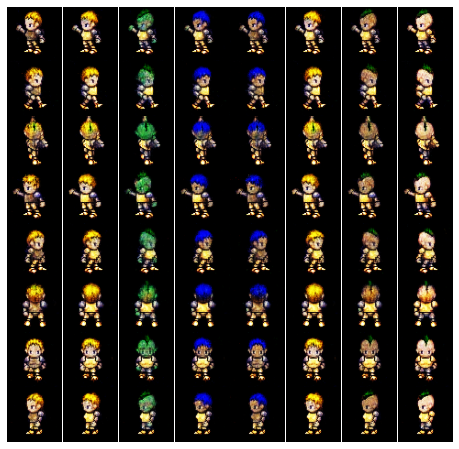

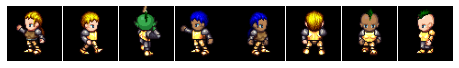

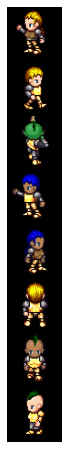

In [33]:
col=[]
row=[]
x1=torch.FloatTensor(1,num_channels,image_size,image_size).to(device)
x2=torch.FloatTensor(1,num_channels,image_size,image_size).to(device)

  
## model style grid transfer
for i in range(8):
    image,_=test_df[random.randint(0,len(test_df)-1)]
    col.append(image)

    row.append(image)

encoder=Encoder(style_dim,class_dim).to(device)
decoder=Decoder(style_dim,class_dim).to(device)
encoder.load_state_dict(torch.load('Outputs/Q2/checkpoints/encoder_weights_new/encoder199.pt'))
decoder.load_state_dict(torch.load('Outputs/Q2/checkpoints/decoder_weights_new/decoder199.pt'))

## complete grid
gs1=gridspec.GridSpec(8,8,width_ratios=[1,1,1,1,1,1,1,1],height_ratios=[1,1,1,1,1,1,1,1],wspace=0,hspace=0)
fig1=plt.figure(figsize=(8,8))

for i in range(len(row)):
    x1.copy_(row[i])
    style_mu,style_logvar,class_latent=encoder(Variable(x1))
    for j in range(len(col)):
        x2.copy_(col[j])
        style_mu2,style_logvar2,class_latent2=encoder(Variable(x2))
        reconstructed_img=decoder(style_mu,class_latent2)
        reconstructed_img=reconstructed_img.squeeze(0)
        reconstructed_img=np.transpose(reconstructed_img.cpu().data.numpy(),(1,2,0))
        ax=plt.subplot(gs1[i,j])
        ax.axis('off')
        ax.imshow(reconstructed_img)
## row print
gs2=gridspec.GridSpec(1,8,width_ratios=[1,1,1,1,1,1,1,1],wspace=0,hspace=0)
fig2=plt.figure(figsize=(8,1))
for i in range(8):
    image=row[i]
    image=image.squeeze(0)
    image=np.transpose(image.cpu().data.numpy(),(1,2,0))
    image=image.astype('float')
    ax=plt.subplot(gs2[i])
    ax.axis('off')
    ax.imshow(image)
##column
fig3=plt.figure(figsize=(1,8))
gs3=gridspec.GridSpec(8,1,height_ratios=[1,1,1,1,1,1,1,1],wspace=0,hspace=0)
for i in range(8):
    image=col[i]
    image=image.squeeze(0)
    image=np.transpose(image.cpu().data.numpy(),(1,2,0))
    image=image.astype('float')
    ax=plt.subplot(gs3[i])
    ax.axis('off')
    ax.imshow(image)

#QUESTION 3


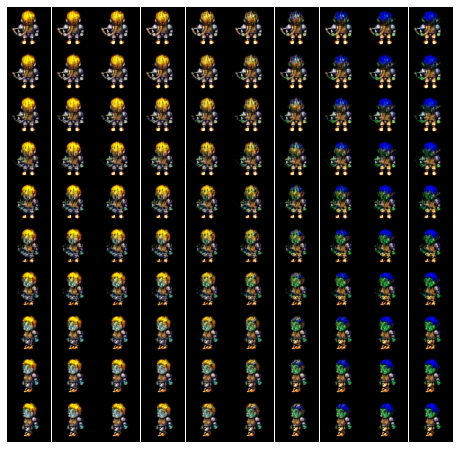

In [38]:

encoder=Encoder(style_dim,class_dim).to(device)
decoder=Decoder(style_dim,class_dim).to(device)
encoder.load_state_dict(torch.load('Outputs/Q2/checkpoints/encoder_weights_new/encoder199.pt'))
decoder.load_state_dict(torch.load('Outputs/Q2/checkpoints/decoder_weights_new/decoder199.pt'))

## complete grid
gs1=gridspec.GridSpec(10,10,width_ratios=[1,1,1,1,1,1,1,1,1,1],height_ratios=[1,1,1,1,1,1,1,1,1,1],wspace=0,hspace=0)
fig1=plt.figure(figsize=(8,8))
x1=torch.FloatTensor(1,num_channels,image_size,image_size).to(device)
x2=torch.FloatTensor(1,num_channels,image_size,image_size).to(device)
image1,_=test_df[random.randint(0,len(test_df)-1)]
image2,_=test_df[random.randint(0,len(test_df)-1)]
x1.copy_(image1)
x2.copy_(image2)

style_mu1,style_logvar1,class_latent1=encoder(Variable(x1))
style_mu2,style_logvar2,class_latent2=encoder(Variable(x2))
diff_style=style_mu2-style_mu1
diff_class=class_latent2-class_latent1
n=10
inter_style=torch.zeros((n,1,diff_style.shape[1])).to(device)
inter_class=torch.zeros((n,1,diff_class.shape[1])).to(device)
for i in range(n):
    inter_style[i]=style_mu1+(i/(n-1))*diff_style
    inter_class[i]=class_latent1+(i/(n-1))*diff_class

for i in range(10):
    for j in range(10):
        reconstructed_img=decoder(inter_style[i],inter_class[j])
        reconstructed_img=reconstructed_img.squeeze(0)
        reconstructed_img=np.transpose(reconstructed_img.cpu().data.numpy(),(1,2,0))
        ax=plt.subplot(gs1[i,j])
        ax.axis('off')
        ax.imshow(reconstructed_img)

plt.savefig('q1_inter.png',dpi=300)

In [0]:

encoder=Encoder(style_dim,class_dim).to(device)
decoder=Decoder(style_dim,class_dim).to(device)
encoder.load_state_dict(torch.load('Outputs/Q2/checkpoints/encoder_weights_new/encoder199.pt'))
decoder.load_state_dict(torch.load('Outputs/Q2/checkpoints/decoder_weights_new/decoder199.pt'))

## complete grid
gs1=gridspec.GridSpec(10,10,width_ratios=[1,1,1,1,1,1,1,1,1,1],height_ratios=[1,1,1,1,1,1,1,1,1,1],wspace=0,hspace=0)
fig1=plt.figure(figsize=(8,8))
x1=torch.FloatTensor(1,num_channels,image_size,image_size).to(device)
x2=torch.FloatTensor(1,num_channels,image_size,image_size).to(device)
image1,_=test_df[random.randint(0,len(test_df)-1)]
image2,_=test_df[random.randint(0,len(test_df)-1)]
x1.copy_(image1)
x2.copy_(image2)

style_mu1,style_logvar1,class_latent1=encoder(Variable(x1))
style_mu2,style_logvar2,class_latent2=encoder(Variable(x2))
diff_style=style_mu2-style_mu1
diff_class=class_latent2-class_latent1
n=10
inter_style=torch.zeros((n,1,diff_style.shape[1])).to(device)
inter_class=torch.zeros((n,1,diff_class.shape[1])).to(device)
for i in range(n):
    inter_style[i]=style_mu1+(i/(n-1))*diff_style
    inter_class[i]=class_latent1+(i/(n-1))*diff_class

for i in range(10):
    for j in range(10):
        reconstructed_img=decoder(inter_style[i],inter_class[j])
        reconstructed_img=reconstructed_img.squeeze(0)
        reconstructed_img=np.transpose(reconstructed_img.cpu().data.numpy(),(1,2,0))
        ax=plt.subplot(gs1[i,j])
        ax.axis('off')
        ax.imshow(reconstructed_img)

plt.savefig('q2_inter.png',dpi=300)

In [0]:

encoder=Encoder(style_dim,class_dim).to(device)
decoder=Decoder(style_dim,class_dim).to(device)
encoder.load_state_dict(torch.load('Outputs/Q2/checkpoints/encoder_weights_new/encoder199.pt'))
decoder.load_state_dict(torch.load('Outputs/Q2/checkpoints/decoder_weights_new/decoder199.pt'))

## complete grid
gs1=gridspec.GridSpec(10,10,width_ratios=[1,1,1,1,1,1,1,1,1,1],height_ratios=[1,1,1,1,1,1,1,1,1,1],wspace=0,hspace=0)
fig1=plt.figure(figsize=(8,8))
x1=torch.FloatTensor(1,num_channels,image_size,image_size).to(device)
x2=torch.FloatTensor(1,num_channels,image_size,image_size).to(device)
image1,_=test_df[random.randint(0,len(test_df)-1)]
image2,_=test_df[random.randint(0,len(test_df)-1)]
x1.copy_(image1)
x2.copy_(image2)

style_mu1,style_logvar1,class_latent1=encoder(Variable(x1))
style_mu2,style_logvar2,class_latent2=encoder(Variable(x2))
diff_style=style_mu2-style_mu1
diff_class=class_latent2-class_latent1
n=10
inter_style=torch.zeros((n,1,diff_style.shape[1])).to(device)
inter_class=torch.zeros((n,1,diff_class.shape[1])).to(device)
for i in range(n):
    inter_style[i]=style_mu1+(i/(n-1))*diff_style
    inter_class[i]=class_latent1+(i/(n-1))*diff_class

for i in range(10):
    for j in range(10):
        reconstructed_img=decoder(inter_style[i],inter_class[j])
        reconstructed_img=reconstructed_img.squeeze(0)
        reconstructed_img=np.transpose(reconstructed_img.cpu().data.numpy(),(1,2,0))
        ax=plt.subplot(gs1[i,j])
        ax.axis('off')
        ax.imshow(reconstructed_img)

plt.savefig('q3_inter.png',dpi=300)